<a href="https://colab.research.google.com/github/melissamelton/BachelorAnalysis/blob/main/TheBachelorAnalysis_GSB521.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The Bachelor Analysis- *Which Demographic Variables Play a Role in Contestant Success Likelihood***


*By Melissa Melton (mnmelton@calpoly.edu) & Annika Bertelsen (abertels@calpoly.edu)*

February 22, 2023

**Brief Background**: A single bachelor (or bachelorette) dates a group of approximately 30 women (or men) over several weeks, narrowing the group of contestants down week by week after a series of one-on-one or group dates to hopefully find true love.

Our goal of this Bachelor and Bachelorette themed data analysis is to gather historical data of all participating contestants from past seasons, to be able to identify any trends within contestant demographics.
Focusing on the Winner of each season, as well as contestants who made it to the Top Four, we will utilize demographics of age, occupation, and home state to examine how much each variable contributes to contestants' success likelihood.

**Hypothesis:** One of our driving questions was which variables, if any, from contestant demographics will be the most important in determining how far the contestant makes it to the end? Here, we hypothesize that Age will be the most significant predictor for the Bachelor, while Occupation will be the most significant for the Bachelorette. This hypothesis is rooted in sterotypes that men may tend to go for the younger woman while women may put high value on suitors' occupations. We don't believe State will play a big role in who a season's lead chooses, but we predict most contestants and winners will be from CA and FL.

In [1]:
import pandas as pd
import requests
import numpy as np
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import matplotlib.image as  image
import seaborn as sns

# The Bachelor Data Gathering & Cleaning

We will start by gathering data on contestants from the Bachelor.

## Scraping

Obtain a list of the seasons we can scrape data from on Wikipedia:

In [2]:
# The Bachelor has had 26 seasons so far (27 is currently airing so it will not be included)
seasons = np.arange(1, 27, 1)
# seasons 3, 4, and 6-8 do not have contestant data on Wikipedia
missing_table = {3, 4, 6, 7, 8}
# obtain list of season numbers which have contestant data on their wiki page
seasons = [x for x in seasons if x not in missing_table]

We will now use the BeautifulSoup library to scrape data about contestants from Wikipedia.

In [3]:
contestants_df = pd.DataFrame()
urlstart = "https://en.wikipedia.org/wiki/The_Bachelor_(American_season_"

def seasons_scrape(seasons, contestants_df, urlstart):
  # loop through seasons
  for i in range(0, len(seasons)):
    # write the url for specific season
    wikiurl = urlstart + str(seasons[i]) + ")"
    table_class = "wikitable sortable jquery-tablesorter"
    response = requests.get(wikiurl)
    # parse data from html
    soup = BeautifulSoup(response.text, 'html.parser')
    contestant_table = soup.find('table', {'class':"wikitable"})
    df = pd.read_html(str(contestant_table))
    # convert list to dataframe
    df = pd.DataFrame(df[0])
    # add column for the season (value the same for all rows from that season)
    df['Season'] = seasons[i]
    # seasons 1 and 2 have a different label for the Outcome and Occupation columns
    if 'Eliminated' in df.columns and 'Job' in df.columns:
      df.rename(columns = {'Eliminated': 'Outcome',
                           'Job': 'Occupation'}, inplace = True)
    # keep only desired columns
    df = df[['Season', 'Name', 'Age', 'Hometown', 'Occupation', 'Outcome']]
    contestants_df = contestants_df.append(df, ignore_index = True)
  return contestants_df


In [4]:
contestants_df = seasons_scrape(seasons, contestants_df, urlstart)

Unfortunately, full contestant data cannot be found online for seasons 3, 4, 6, 7, and 8 (even the Bachelor Nation fandom Wiki does not have it). So, our resulting dataframe only represents 21 of the 26 full seasons.

## Cleaning

Perform clean-up on the contestants_df dataframe.

In [5]:
# sometimes contestants will leave one week then return a later week. Remove the
# rows from the table which reference them leaving (the info we care about is stored
# in another row, including their final placement)
contestants_df[contestants_df['Age'] == "(Returned to competition)"]

# remove these rows -- the data for these contestants is still in the table, just a different row
contestants_df = contestants_df[contestants_df['Age'] != "(Returned to competition)"]

In [6]:
# some contestants' names had hyperlinks. Remove the references attached
contestants_df['Name'] = contestants_df['Name'].apply(lambda x: x.split('[')[0]
                                                      if '[' in x else x)
# separate town and state into their own columns
contestants_df[['Town', 'State']] = contestants_df.Hometown.str.split(',', expand = True)
# make sure age is numeric
contestants_df['Age'] = pd.to_numeric(contestants_df['Age'])

# keep desired columns
cols = ['Season', 'Name', 'Age', 'Town', 'State', 'Occupation', 'Outcome']
contestants_df = contestants_df[cols]

In [7]:
contestants_df

,Season,Name,Age,Town,State,Occupation,Outcome
0,1,Amanda Marsh,23.0,Chanute,Kansas,Event Planner,Winner
1,1,Trista Rehn,29.0,St. Louis,Missouri,Miami Heat Dancer,Runner-up
2,1,Shannon Oliver,24.0,Dallas,Texas,Financial Management Consultant,Week 5
3,1,Kim,24.0,Tempe,Arizona,Nanny,Week 4
4,1,Cathy Grimes,22.0,Terre Haute,Indiana,Graduate Student,Week 3
...,...,...,...,...,...,...,...
578,26,Jane Paik,33.0,Santa Monica,California,Social Media Director,Week 1
579,26,Lindsay Dobbs,27.0,Warner Robins,Georgia,Neonatal Nurse,Week 1
580,26,Rianna Hockaday,26.0,Mount Pleasant,Texas,Registered Nurse,Week 1
581,26,Samantha Jeffries,26.0,Dayton,Ohio,Occupational Therapist,Week 1


Create a new data frame representing all winners of the show. Note: Season 11 notoriously does not have a winner--that season's bachelor Brad Womack infamously broke up with both his final two women!

Create another new data frame with the top four contestants from each season.

In [8]:
# winners
winners_df = contestants_df[contestants_df['Outcome'] == "Winner"]

# top 4
top4_df = contestants_df.groupby('Season').head(4)

## Occupation Categorization 
The contestant occupations are specific to the individual. To better analyze trends in popular occupations, we will create a dictionary to categorize contestants' jobs. We created this dictionary based on common themes identified in the jobs of contestants in the top 4 of each season.

In [9]:
# set up key words we will use for detecting occupation categories
marketing = ['Marketing', 'Content', 'Publicist', 'Communications', 'Social Media', 'Advertising']
sales = ['Sales', 'Salesperson', 'Account Executive']
finance = ['Finance', 'Financial']
managmentconsult = ['Consultant', 'Business', 'Buyer', 'Executive Assistant',
                    'Recruiter', 'Administrative']
teacher = ['Teacher']
student = ['Student']
medical = ['Nurse', 'Hospital', 'Chiropractic', 'Phlebotomist']
dance = ['Dancer', 'Dance Instructor', 'Cheerleader']
therapy = ['Psychologist', 'Therapist', 'Speech Pathologist']
dental = ['Dental']
realestate = ['Real Estate', 'Realtor']
attorney = ['Attorney']
flight = ['Flight']
arts = ['Graphic Designer', 'Creative Director', 'Photographer', 'Videographer', 'Actress', 'Designer']
beauty = ['Stylist', 'Hairstylist', 'Esthetician', 'Fashion', 'Cosmetics', 'Clothier']
events = ['Event Planner', 'Bridal', 'Funeral Director']
model = ['Model']
construction = ['Contractor']
socialwork = ['Social Worker']

# create a dictionary of job categories, with the values representing the list of jobs within the key
job_dictionary1 = {'Marketing': marketing, 'Sales': sales, 'Teaching': teacher, 
                   'Finance': finance, 'Management and Consulting': managmentconsult,
                  'Medical': medical, 'Dance': dance, 'Therapy': therapy,
                  'Dental Care': dental, 'Real Estate': realestate, 'Legal': attorney, 
                  'Flight': flight, 'Arts': arts, 'Beauty': beauty, 
                  'Events': events, 'Modeling': model, 'Student': student,
                   'Construction': construction, 'Social Work': socialwork}

This function will look at the occupation of each contestant in a data frame and then look through each key, value pair in the provided job dictionary. If the contestant's occupation matches a job in one of the keys, the name of that key will be inputted as their job category. If the contestant's job does not appear in the dictionary, the category will be designated as "Not Found".

Note: we are only running this function for the top 4 and winners dataframes since these contestants' jobs were the ones used in designing the dictionary.

In [10]:
def calculateJobCategory(row):
  occupation = row['Occupation'].casefold()

  for k, v in job_dictionary1.items():
    for occupation_keywords in v:
      if occupation_keywords.casefold() in occupation:
        return k

  #print(f"did not find {occupation}")
  return "not found"

top4_df['Job Category'] = top4_df.apply(calculateJobCategory, axis=1)
winners_df['Job Category'] = winners_df.apply(calculateJobCategory, axis=1)

# counts of each job category among all Bachelorette contestants who made top 4
top4_df['Job Category'].value_counts()

<ipython-input-10-d7b5bab1e4a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top4_df['Job Category'] = top4_df.apply(calculateJobCategory, axis=1)
<ipython-input-10-d7b5bab1e4a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winners_df['Job Category'] = winners_df.apply(calculateJobCategory, axis=1)


Arts                         9
Marketing                    9
Management and Consulting    7
Medical                      7
Sales                        6
Beauty                       6
Teaching                     6
not found                    5
Modeling                     4
Real Estate                  4
Therapy                      3
Student                      3
Dance                        3
Flight                       3
Dental Care                  2
Events                       2
Legal                        2
Social Work                  1
Construction                 1
Finance                      1
Name: Job Category, dtype: int64

In [11]:
top4_df

,Season,Name,Age,Town,State,Occupation,Outcome,Job Category
0,1,Amanda Marsh,23.0,Chanute,Kansas,Event Planner,Winner,Events
1,1,Trista Rehn,29.0,St. Louis,Missouri,Miami Heat Dancer,Runner-up,Dance
2,1,Shannon Oliver,24.0,Dallas,Texas,Financial Management Consultant,Week 5,Finance
3,1,Kim,24.0,Tempe,Arizona,Nanny,Week 4,not found
25,2,Helene Eksterowicz,27.0,Gloucester,New Jersey,School Psychologist,Winner,Therapy
...,...,...,...,...,...,...,...,...
518,25,Serena Pitt,23.0,Markham,Ontario,Publicist,Week 8,Marketing
552,26,Susie Evans,28.0,Poquoson,Virginia,Wedding Videographer,Winner,Arts
553,26,"Gabriela ""Gabby"" Windey",30.0,O'Fallon,Illinois,ICU Nurse,Runner-Up(Week 10),Medical
554,26,Rachel Recchia,25.0,Clermont,Florida,Flight Instructor,Runner-Up(Week 10),Flight


# The Bachelorette Data Gathering & Cleaning

Now we will perform the same process, but for contestants on the Bachelorette, where a female lead dates a group of male suitors.

## Scraping

Once again, we create an array representing the seasons we can obtain data from on Wikipedia. Thankfully this time, all seasons have contestant data available.

In [12]:
# The Bachelorette has had 19 seasons so far
seasons = np.arange(1, 20, 1)

Use the BeautifulSoup library to create a data frame containing information on all Bachelorette contestants, using the seasons_scrape() function from the prior section.

In [13]:
# create new contestant data frame for Bachelorette
contestants_df2 = pd.DataFrame()
urlstart = "https://en.wikipedia.org/wiki/The_Bachelorette_(American_season_"

# call seasons_scrape() function
contestants_df2 = seasons_scrape(seasons, contestants_df2, urlstart)

## Cleaning

Perform some clean-up on the contestants dataframe:

In [14]:
# sometimes contestants will leave one week then return a later week. Remove the
# rows from the table which reference them leaving (the info we care about is stored
# in another row, including their final placement)
contestants_df2[contestants_df2['Age'] == "(Returned to competition)"]

# remove these rows -- the data for these contestants is still in the table, just a different row
contestants_df2 = contestants_df2[contestants_df2['Age'] != "(Returned to competition)"]

contestants_df2 = contestants_df2.dropna(axis=0)

In [15]:
# some contestants' names had hyperlinks. Remove the references attached
contestants_df2['Name'] = contestants_df2['Name'].apply(lambda x: x.split('[')[0] if '[' in x else x)
# fix some unclean age values
contestants_df2['Age'] = contestants_df2['Age'].apply(str).apply(lambda x: x.split('[')[0] if '[' in x else x)
# separate town and state into their own columns
contestants_df2[['Town', 'State']] = contestants_df2['Hometown'].str.split(',', expand = True)
# make sure age is numeric
contestants_df2['Age'] = pd.to_numeric(contestants_df2['Age'])

# keep desired columns
cols = ['Season', 'Name', 'Age', 'Town', 'State', 'Occupation', 'Outcome']
contestants_df2 = contestants_df2[cols]

In [16]:
contestants_df2

,Season,Name,Age,Town,State,Occupation,Outcome
0,1,Ryan Sutter,28,Vail,Colorado,Firefighter,Winner
1,1,Charlie Maher,28,Hermosa Beach,California,Financial Analyst,Runner-up
2,1,Russell Woods,31,San Rafael,California,Writer,Week 5
3,1,Greg Todtman,28,Manhattan,New York,Importer,Week 4
4,1,Bob Guiney,31,Ferndale,Michigan,Mortgage Broker,Week 3
...,...,...,...,...,...,...,...
525,19,Chris Austin,30,Redondo Beach,California,Mentality Coach,Week 2
526,19,Jordan Vandergriff,27,Alpharetta,Georgia,Drag Racer,Week 2
527,19,Joey Young,24,Brookfield,Connecticut,Twin,Week 1
528,19,Justin Young,24,Brookfield,Connecticut,Other Twin,Week 1


Create two new data frames for the winners and top 4 of each season. It should be noted that two Bachelorette seasons are rather special--seasons 16 and 19 both had two different Bachelorettes, so they will each have two winners!

In [17]:
# winners
winners_df2 = contestants_df2[contestants_df2['Outcome'] == "Winner"]

# top 4
top4_df2 = contestants_df2.groupby('Season').head(4)

## Occupation Categorization

We will create a different jobs dictionary, since the male contestants tend to have different jobs from the female contestants. Like we did with the female contestants, we observed common trends among the top 4 contestants from each season to create this dictionary.

In [27]:
# set up key words we will use for detecting occupation categories
marketing = ['Marketing', 'Content', 'Publicist', 'Communications', 'Social Media']
finance = ['Banker', 'Portfolio', 'Equity', 'Financial', 'Investment']
sales = ['Sales', 'Salesperson', 'Salesman', 'Insurance Agent']
managementconsult = ['Consultant', 'Business', 'Buyer', 'Entrepreneur', 
                     'Wine', 'Restaurant', 'Startup', 'Account Executive', 'Tech Executive',
                     'Retail Manager']
teacher = ['Teacher']
student = ['Student']
medical = ['Nurse', 'Hospital', 'Chiropractor', 'Medicine']
sports = ['Snowboarder', 'Football', 'Quarterback', 'Swimmer',' Trainer', 'Race', 
          'Baseball', 'Basketball', 'Personal Trainer']
therapy = ['Psychologist', 'Therapist', 'Speech Pathologist', 'Addiction Specialist']
dental = ['Dental']
arts = ['Singer', 'Photographer', 'Writer', 'Musician', 'Art']
realestate = ['Real Estate', 'Realtor', 'Mortgage']
attorney = ['Attorney']
flight = ['Flight', 'Pilot']
engineer = ['Engineer']
armyvet = ['Army', 'Veteran']
construction = ['General Contractor', 'Construction', 'Landscaper']

# create a dictionary of job categories, with the values representing the list of jobs within the key
job_dictionary2 = {'Marketing': marketing, 'Finance': finance, 'Sales': sales, 'Teaching': teacher, 'Management and Consulting': managementconsult,
                  'Medical': medical, 'Sports': sports, 'Arts': arts, 'Therapy': therapy,
                  'Dental Care': dental, 'Real Estate': realestate, 'Legal': attorney, 
                  'Flight': flight, 'Engineering': engineer, 
                  'Army or Veteran': armyvet, 'Student': student, 'Construction': construction}

In [28]:
def calculateJobCategory(row):
  occupation = row['Occupation'].casefold()

  for k, v in job_dictionary2.items():
    for occupation_keywords in v:
      if occupation_keywords.casefold() in occupation:
        return k

  #print(f"did not find {occupation}")
  return "not found"

top4_df2['Job Category'] = top4_df2.apply(calculateJobCategory, axis=1)
winners_df2['Job Category'] = winners_df2.apply(calculateJobCategory, axis=1)

# counts of each job category among all Bachelorette contestants who made top 4
top4_df2['Job Category'].value_counts()

<ipython-input-28-1ecf9a92a34f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top4_df2['Job Category'] = top4_df2.apply(calculateJobCategory, axis=1)
<ipython-input-28-1ecf9a92a34f>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winners_df2['Job Category'] = winners_df2.apply(calculateJobCategory, axis=1)


Sales                        16
Management and Consulting    14
Sports                       10
not found                     6
Finance                       5
Real Estate                   5
Arts                          4
Construction                  4
Medical                       3
Marketing                     2
Engineering                   2
Army or Veteran               2
Teaching                      1
Flight                        1
Therapy                       1
Name: Job Category, dtype: int64

In [20]:
top4_df2

,Season,Name,Age,Town,State,Occupation,Outcome,Job Category
0,1,Ryan Sutter,28,Vail,Colorado,Firefighter,Winner,not found
1,1,Charlie Maher,28,Hermosa Beach,California,Financial Analyst,Runner-up,Finance
2,1,Russell Woods,31,San Rafael,California,Writer,Week 5,Arts
3,1,Greg Todtman,28,Manhattan,New York,Importer,Week 4,not found
25,2,Ian McKee,29,New York,New York,Equity Research Salesman,Winner,Finance
...,...,...,...,...,...,...,...,...
470,18,Rodney Mathews,29,Rancho Cucamonga,California,Sales Representative,Week 7,Sales
497,19,Tino Franco,28,Valencia,California,General Contractor,Winner,Construction
498,19,Erich Schwer,29,Bedminster,New Jersey,Real Estate Analyst,Winner,Real Estate
499,19,Aven Jones,28,Beverly,Massachusetts,Sales Executive,Runner-Up,Sales


# Visualization of Contestant Demographics

## Contestants by Age

To start our investigation into contestants' age, we will first show boxplots of all contestant ages by season for both franchises.

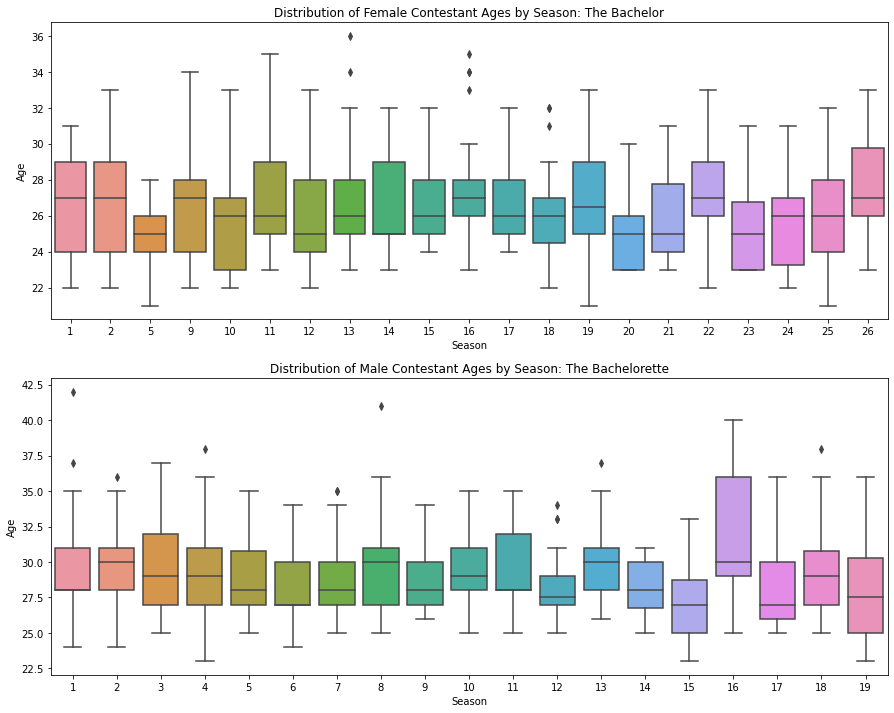

In [21]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize=(15, 12))

#distribution of ALL Contestant ages by season: Bachelor
sns.boxplot(x='Season', y='Age', data = contestants_df, ax=ax[0])
ax[0].set_title("Distribution of Female Contestant Ages by Season: The Bachelor")

#distribution of ALL Contestant ages by season: Bachelorette
sns.boxplot(x='Season', y='Age', data = contestants_df2, ax=ax[1])
ax[1].set_title("Distribution of Male Contestant Ages by Season: The Bachelorette") 
# show the graph
plt.show()

**Overall (all Contestants, all Seasons) mean ages were as follows:**  

Female Mean Age: 26.3 years old 

Male Mean Age: 29.1 years old 


Now, we will examine how the distribution of contestant ages for all seasons on the Bachelor varies Overall, among the Top 4 contestants, and among the Winners.

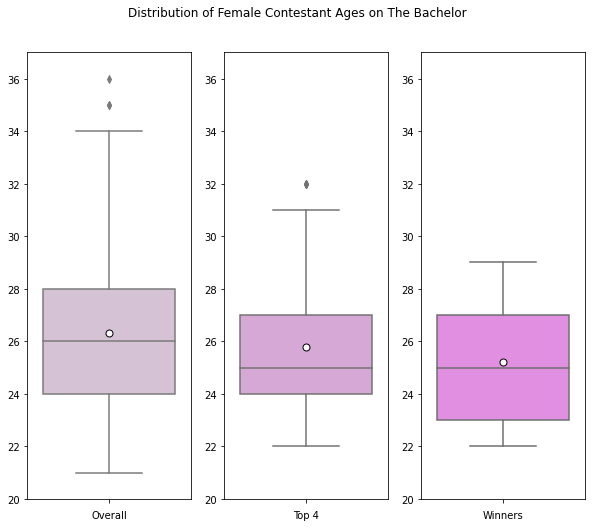

In [22]:
df_list = [contestants_df, top4_df, winners_df]
df_names = ['Overall', 'Top 4', 'Winners']
colors = ['thistle', 'plum', 'violet']
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (10,8))

for c in range(3):
  sns.boxplot(y='Age', data = df_list[c], ax=axes[c], color=colors[c], 
              showmeans = True, meanprops = {'marker': 'o',
                                             'markerfacecolor': 'white',
                                             'markeredgecolor': 'black',
                                             'markersize': 7})
  axes[c].set(ylabel='', xlabel=df_names[c])
  axes[c].set_ylim(20,37)
  axes[c].set_facecolor

fig.subplots_adjust(top=0.9)
fig.suptitle("Distribution of Female Contestant Ages on The Bachelor")
plt.show()

The boxplot demonstrates that the mean age Overall (all contestants) is slightly over 26, but for the Top 4 and the Winners, it slightly decreases to 25, with the Winners having the lowest mean age. We see that the variability in age also decreases from Overall to Top 4 to Winners. No woman over 29 has won the show before. This supports our hypothesis that the Bachelors tend to favor younger women, with ages 23-27 being the most popular.

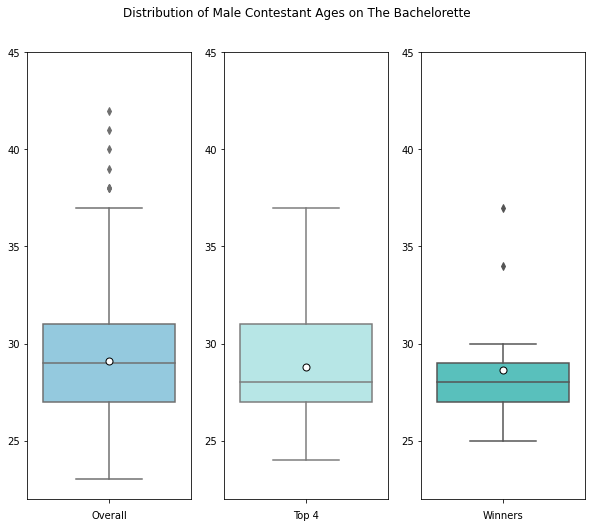

In [23]:
df_list = [contestants_df2, top4_df2, winners_df2]
df_names = ['Overall', 'Top 4', 'Winners']
colors = ['skyblue', 'paleturquoise', 'mediumturquoise']
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (10,8))

for c in range(3):
  sns.boxplot(y='Age', data = df_list[c], ax=axes[c], color=colors[c], 
              showmeans = True, meanprops = {'marker': 'o',
                                             'markerfacecolor': 'white',
                                             'markeredgecolor': 'black',
                                             'markersize': 7})
  axes[c].set(ylabel='', xlabel=df_names[c])
  axes[c].set_ylim(22, 45)
  axes[c].set_facecolor

fig.subplots_adjust(top=0.9)
fig.suptitle("Distribution of Male Contestant Ages on The Bachelorette")
plt.show()

The mean age of male contestants looks to be around 28 years old for all subgroups- Overall, Top 4, and Winners. The distributions of the Overall and Top 4 groups are quite similar, except for a few outliers in the Overall grouping. For Winners, the IQR is much smaller. The majority of Winners are between ages 27-29. This narrow range of low age values is smaller than we expected; we expected more of the men who won to be in their early thirties. 

We had expected age to be a factor the Bachelors used to narrow down their top choices among the women, but the Bachelorettes seem to also be quite selective in their age preference of men!

## Contestants by Occupation

To determine the most common occupations among Winners or contestants who place in the Top 4, we will use a barplot, including the 7 most popular job categories.

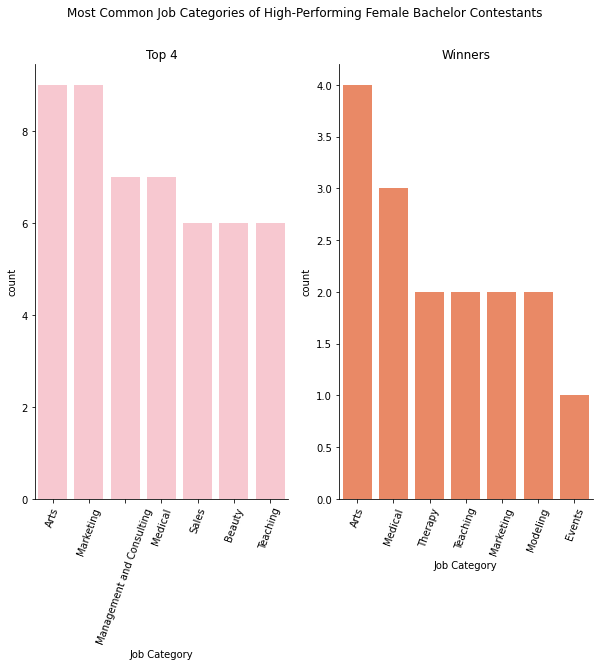

In [34]:
#Job Categories for: Top 4 female contestants AND Winning contestants: The Bachelor
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10,8))

order_top4 = top4_df["Job Category"].value_counts().iloc[:7].index
order_winners = winners_df["Job Category"].value_counts().iloc[:7].index

sns.countplot(x = top4_df["Job Category"], color="pink", ax = axes[0],
              order=order_top4).set(title="Top 4")
axes[0].set_xticklabels(order_top4, rotation = 70)

sns.countplot(x = winners_df["Job Category"], color="coral", ax = axes[1],
              order=order_winners).set(title="Winners")
axes[1].set_xticklabels(order_winners, rotation = 70)

fig.suptitle('Most Common Job Categories of High-Performing Female Bachelor Contestants')
sns.despine()

Arts and Medicine are the leading job categories for female Winners, with categories Therapy, Teaching, Marketing, and Modeling tied with 2 wins each. 
Arts, marketing, teaching, and medicine are common among both the Top 4 and just Winners. Arts and Marketing are the most common field among contestants who made Top 4. We would expect marketing to be a common occupation for many Bachelor contestants, as the show's contestants sometimes are hopeful to build an influencer career after appearing on the show.

Next, we will do the same visualization of most common Job Categories for the male contestants on The Bachelorette.

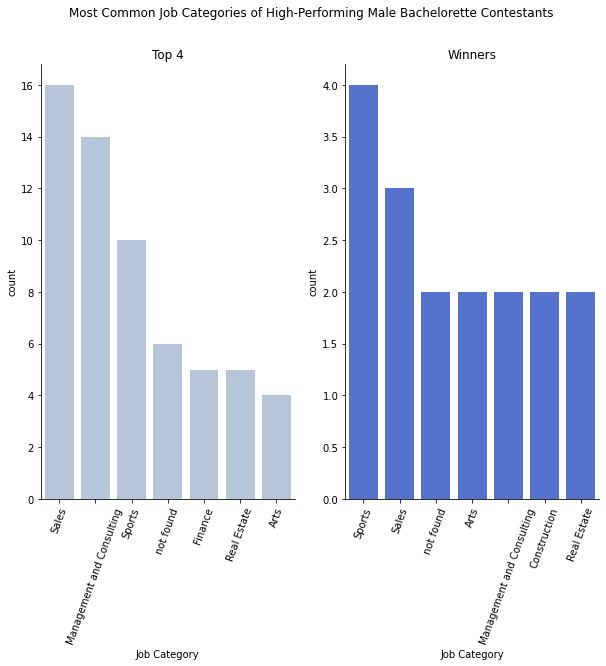

In [35]:
#Job Categories for: Top 4 Male contestants AND Winning Male contestants: The Bachelorette
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10,8))

order_top42 = top4_df2["Job Category"].value_counts().iloc[:7].index
order_winners2 = winners_df2["Job Category"].value_counts().iloc[:7].index

sns.countplot(x = top4_df2["Job Category"], color="lightsteelblue", ax = axes[0],
              order=order_top42).set(title="Top 4")
axes[0].set_xticklabels(order_top42, rotation = 70)

sns.countplot(x = winners_df2["Job Category"], color="royalblue", ax = axes[1],
              order=order_winners2).set(title="Winners")
axes[1].set_xticklabels(order_winners2, rotation = 70)

fig.suptitle('Most Common Job Categories of High-Performing Male Bachelorette Contestants')
sns.despine()

For males, Sports and Sales are the most common job categories for winners, with 4 and 3 winners, respectively. We expected Sports to be a high-performing category, as the show's Bachelorettes may be interested in dating an athlete. However, we had not considered how popular Sales would be. 16 contestants who made top 4 had sales jobs! We are curious if this is simply because lots of men who appear on the Bachelorette work in sales, or if men who work in sales know how to "sell themselves" as an ideal partner to the Bachelorette and push themselves far on the show.

## Contestants by Home State

Another potential predictor variable we wanted to analyze is Home State of the High Performing (Winners and Top 4) contestants. 

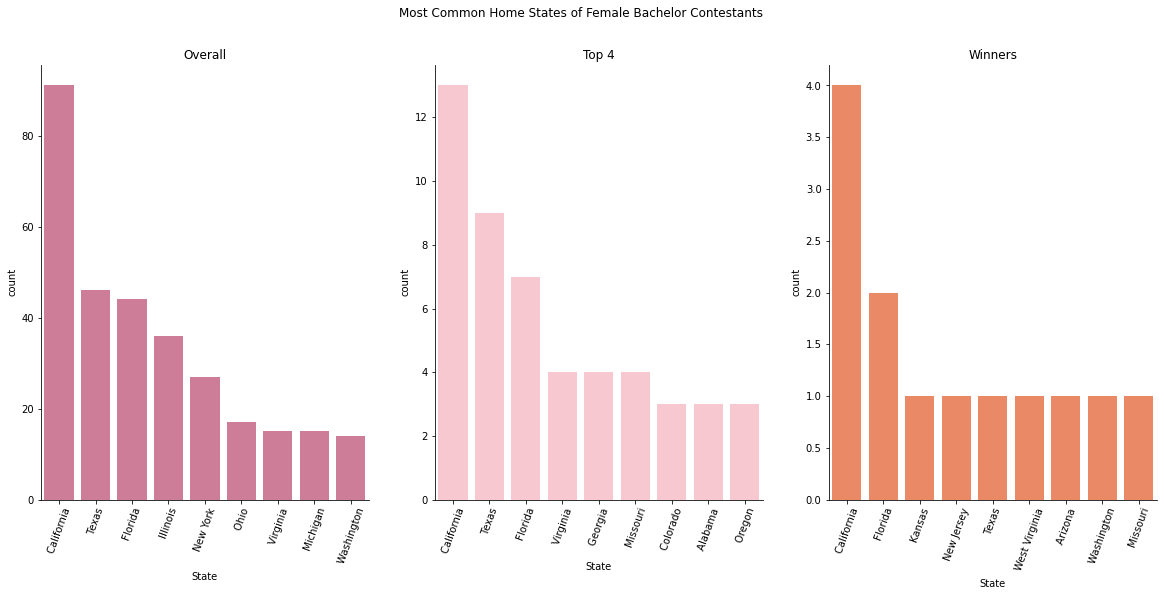

In [36]:
#Popular home states for Overall, Winners, and Top 4: The Bachelor
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (20,8))

order_overall = contestants_df["State"].value_counts().iloc[:9].index
order_top4 = top4_df["State"].value_counts().iloc[:9].index
order_winners = winners_df["State"].value_counts().iloc[:9].index

sns.countplot(x = contestants_df["State"], color="palevioletred", ax = axes[0],
              order=order_overall).set(title="Overall")
axes[0].set_xticklabels(order_overall, rotation = 70)

sns.countplot(x = top4_df["State"], color="pink", ax = axes[1],
              order=order_top4).set(title="Top 4")
axes[1].set_xticklabels(order_top4, rotation = 70)

sns.countplot(x = winners_df["State"], color="coral", ax = axes[2],
              order=order_winners).set(title="Winners")
axes[2].set_xticklabels(order_winners, rotation = 70)

fig.suptitle('Most Common Home States of Female Bachelor Contestants')
sns.despine()

Here we can see that many of the high performing contestants (Winners and Top 4) live in California and Florida. Many top 4 contestants also are from Texas. These three states are the most represented among all contestants, so this is not surprising. However, it is a bit interesting that Illinois and New York are the next two most popular states overall, and no winners have come from either of those two states (and only one person from both those states has even reached the top 4!).

Now, we will take a look at home state among contestants on the Bachelorette.

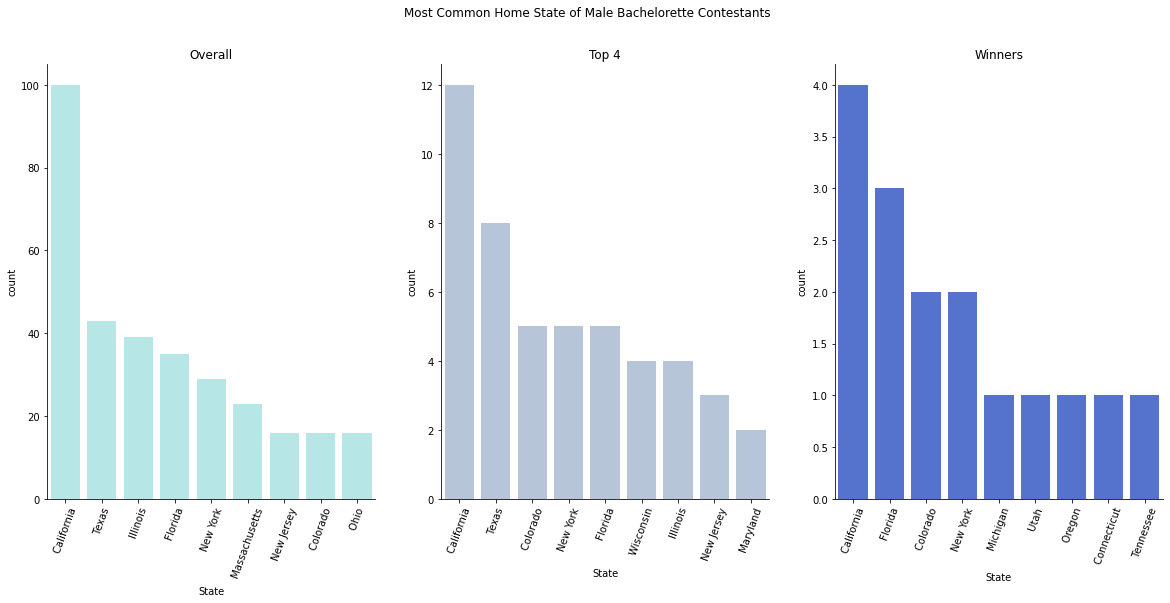

In [37]:
#Popular home states for Overall, Winners, and Top 4: The Bachelorette
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (20,8))

order_overall2 = contestants_df2["State"].value_counts().iloc[:9].index
order_top4_2 = top4_df2["State"].value_counts().iloc[:9].index
order_winners2 = winners_df2["State"].value_counts().iloc[:9].index

sns.countplot(x = contestants_df2["State"], color="paleturquoise", ax = axes[0],
              order=order_overall2).set(title="Overall")
axes[0].set_xticklabels(order_overall2, rotation = 70)

sns.countplot(x = top4_df2["State"], color="lightsteelblue", ax = axes[1],
              order=order_top4_2).set(title="Top 4")
axes[1].set_xticklabels(order_top4_2, rotation = 70)

sns.countplot(x = winners_df2["State"], color="royalblue", ax = axes[2],
              order=order_winners2).set(title="Winners")
axes[2].set_xticklabels(order_winners2, rotation = 70)

fig.suptitle('Most Common Home State of Male Bachelorette Contestants')
sns.despine()

Similarly to the Bachelor, most Bachelorette contestants are from California, Texas, Illinois, Florida, and New York. After observing both the plots for the men and womens' home states, we observe that while Texans are one of the largest categories overall and in the Top 4, only one has actually won one of the shows before!

# Next Steps

Some ideas for our next steps would be to find data pertaining to more specific happenings of episodes! We could use this to move beyond demographic data and investigate:

1. What is the probability of winning/making top 4 if you are awarded the coveted "first impression rose"? 
2. For couples from the Bachelor, the median relationship length is less than half a year! Are the couples who went on more one-on-one dates the ones who stayed together longer? 
3. Is there a significant difference between the proportion of couples from the Bachelor versus Bachelorette who last at least one year?